In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

import os
# Set environment variables (local paths)
os.environ["JAVA_HOME"] = "D:/Programs/Java"
os.environ["HADOOP_HOME"] = "D:/Programs/hadoop"
os.environ["SPARK_HOME"] = "D:/Programs/spark/spark-3.5.6-bin-hadoop3"  # Adjust if different

import findspark
findspark.init("D:/Programs/spark/spark-3.5.6-bin-hadoop3")

import time

In [2]:
spark = (
    SparkSession
    .builder
    .appName("Testing AQE")
    .config("spark.executor.memory", "2g")
    .config("spark.executor.cores", "2")
    .master("local[*]")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [3]:
spark.conf.set("spark.sql.shuffle.partitions", "400")
spark.conf.set("spark.sql.adaptive.advisoryPartitionSizeInBytes", "64MB")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 50 * 1024 * 1024)  # Enable broadcast joins

In [4]:
transactions_file = "../../data/transactions.parquet"
customers_file = "../../data/customers.parquet"

df_transactions = spark.read.parquet(transactions_file)
df_customers = spark.read.parquet(customers_file)

In [5]:
# Function to measure time
def measure_time(description, action):
    print(f"\n🔹 {description}")
    start_time = time.time()
    result = action()
    duration = time.time() - start_time
    print(f"⏱️ Time Taken: {duration:.2f} seconds")
    return result, duration

In [6]:
# Aggregation Test
def run_aggregation():
    df_txn_agg = (
        df_transactions.groupBy("cust_id")
        .agg(F.countDistinct("txn_id").alias("ct"))
        .orderBy(F.desc("ct"))
    )
    return lambda: df_txn_agg.count()  # Returns a callable to measure count()

In [7]:
# Join Test
def run_join():
    df_txn_details = (
        df_transactions.join(df_customers, on="cust_id", how="inner")
    )
    return lambda: df_txn_details.count()

In [8]:
# Function to Run Experiments
def run_experiment(aqe_enabled=True):
    print("\n===============================")
    print(f"AQE Enabled: {aqe_enabled}")
    print("===============================")
    spark.conf.set("spark.sql.adaptive.enabled", str(aqe_enabled).lower())
    spark.conf.set("spark.sql.adaptive.skewedJoin.enabled", str(aqe_enabled).lower())

    # Disable Broadcast Join for fair test
    spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

    agg_result, agg_time = measure_time("Transaction Aggregation", run_aggregation())
    join_result, join_time = measure_time("Inner Join (Transactions JOIN Customers)", run_join())

    return {
        "AQE_Enabled": aqe_enabled,
        "Aggregation_Time_sec": agg_time,
        "Join_Time_sec": join_time,
        "Aggregation_Rows": agg_result,
        "Join_Rows": join_result
    }

In [20]:
# Run Both Cases
results_no_aqe = run_experiment(aqe_enabled=False)


🚀 AQE Enabled: False

🔹 Transaction Aggregation
⏱️ Time Taken: 3.43 seconds

🔹 Inner Join (Transactions JOIN Customers)
⏱️ Time Taken: 15.35 seconds


<b> AQE Enabled: False </b>

For Aggregation- <br>
- Time Taken: 5.63 seconds <br>
- Input size- 11.8 MiB <br>
- Shuffle Read- 150.0 KiB<br>
- Shuffle Write- 11.5 KiB <br>
- GC Time- 4 sec <br>
- Stages- 3<br>
- Total Tasks- 214<br><br>

For Inner Join- <br> 
- Time Taken: 14.59 seconds <br>
- Input Size- 12.5 MiB <br>
- Shuffle Read- 8 MiB <br>
- Shuffle Write- 11.5 KiB <br>
- Total GC- 9.3 sec<br>
- Stages- 4<br>
- Total Tasks- 216<br>
- Spill (Memory)- 482 MiB <br><br>

In [21]:
results_with_aqe = run_experiment(aqe_enabled=True)


🚀 AQE Enabled: True

🔹 Transaction Aggregation
⏱️ Time Taken: 0.69 seconds

🔹 Inner Join (Transactions JOIN Customers)
⏱️ Time Taken: 25.31 seconds


<b> AQE Enabled: True </b>

For Transaction Aggregation- <br>
- Time Taken: 1.71 seconds <br> 
- Input size- 11.8 MiB <br>
- Shuffle Read- 150.0 KiB<br>
- Shuffle Write- 50 B <br>
- GC Time- 4 sec <br>
- Stages- 3<br>
- Total Tasks- 15<br><br>

For Inner Join- <br> 
- Time Taken: 11.22 seconds <br>
- Input Size- 12.5 MiB <br>
- Shuffle Read- 8 MiB <br>
- Shuffle Write- 295 B <br>
- Total GC- 9.3 sec<br>
- Stages- 4<br>
- Total Tasks- 20<br>
- Spill (Memory)- 1294 MiB <br><br>

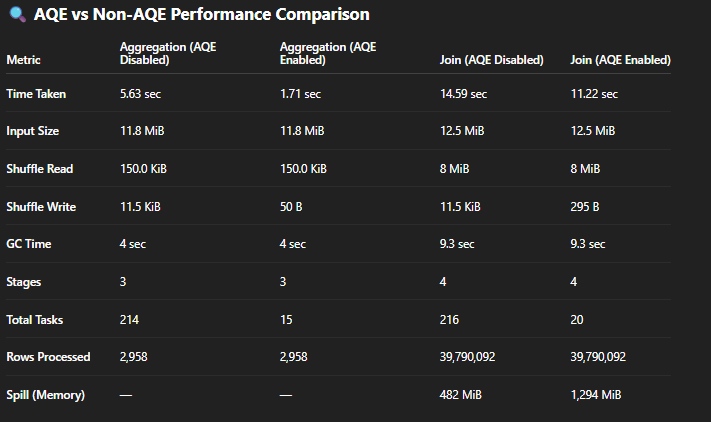

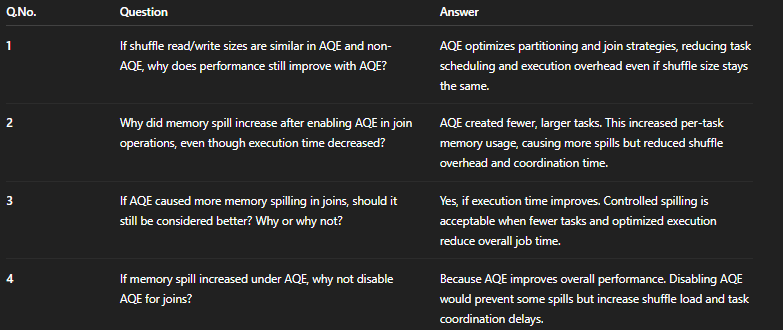

<b> 🚀 Key Recommendations:<br> </b>
1. Increase Executor Memory
→ Set --executor-memory 6G or higher to reduce memory spills.

2. Tune Shuffle Partitions
→ Set spark.sql.shuffle.partitions = 300 (or higher) to avoid large partitions and reduce per-task memory load.

3. Use Broadcast Joins (If Possible)
→ Enable broadcast join for small tables to skip shuffle joins entirely.

4. Monitor & Control Partition Coalescing
→ Ensure AQE’s coalescing doesn't create overly large partitions; adjust if needed.

In [22]:
spark.stop()